<h1>Simple LSTM with Monthly Dataset</h1>

In [61]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')

In [62]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [63]:
chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
king_all_copy, king_data= load_data(ismael_path)
print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [64]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [65]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [66]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [67]:
print(data_copy)

          date    king
0   1939-01-31       6
1   1939-02-28      12
2   1939-03-31     121
3   1939-04-30   51410
4   1939-05-31   25159
..         ...     ...
979 2020-08-31  105269
980 2020-09-30  254930
981 2020-10-31   30917
982 2020-11-30     843
983 2020-12-31       9

[984 rows x 2 columns]


In [68]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
    king_test[king_test["king"] < 0] = 0
    king_train_pre = king_training["king"].to_frame()
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
    
    for i in range(6,924): # 30
        x_train.append(king_train_norm[i-6:i])
        y_train.append(king_train_norm[i])
    for i in range(6, 60):
        x_test.append(king_test_norm[i-6:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm
    for i in range(6, 60):
        y_test_not_norm.append(king_test['king'][i])
    for i in range(6,924): # 30
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [69]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))

(60, 2)


In [70]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def month_to_year(month_preds):
    month_preds = month_preds[5:]
    print(len(month_preds))
    year_preds = []
    for i in range(12, len(month_preds), 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

In [71]:
def create_LSTM_model(x_train, y_train, x_test, y_test): 
    '''
    Create LSTM model trained on X_train and Y_train
    and make predictions on the X_test data
    '''
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(5, input_shape=(x_train.shape[1],1)))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
    history_LSTM = LSTM_model.fit(x_train, y_train, epochs=3000, batch_size=150, verbose=2)
    
    train_preds = LSTM_model.predict(x_train)
    test_preds = LSTM_model.predict(x_test)
    train_preds = scaler.inverse_transform(train_preds)
    test_preds = scaler.inverse_transform(test_preds)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    
    return LSTM_model, test_preds, train_preds, y_test, y_train, history_LSTM

In [72]:
# running LSTM
LSTM_model, test_preds_LSTM, train_preds_LSTM, y_test, y_train, history_LSTM = create_LSTM_model(x_train, y_train, x_test, y_test)

Epoch 1/3000
7/7 - 2s - loss: 0.0131
Epoch 2/3000
7/7 - 0s - loss: 0.0111
Epoch 3/3000
7/7 - 0s - loss: 0.0099
Epoch 4/3000
7/7 - 0s - loss: 0.0095
Epoch 5/3000
7/7 - 0s - loss: 0.0094
Epoch 6/3000
7/7 - 0s - loss: 0.0094
Epoch 7/3000
7/7 - 0s - loss: 0.0094
Epoch 8/3000
7/7 - 0s - loss: 0.0094
Epoch 9/3000
7/7 - 0s - loss: 0.0093
Epoch 10/3000
7/7 - 0s - loss: 0.0093
Epoch 11/3000
7/7 - 0s - loss: 0.0093
Epoch 12/3000
7/7 - 0s - loss: 0.0093
Epoch 13/3000
7/7 - 0s - loss: 0.0093
Epoch 14/3000
7/7 - 0s - loss: 0.0092
Epoch 15/3000
7/7 - 0s - loss: 0.0092
Epoch 16/3000
7/7 - 0s - loss: 0.0092
Epoch 17/3000
7/7 - 0s - loss: 0.0092
Epoch 18/3000
7/7 - 0s - loss: 0.0092
Epoch 19/3000
7/7 - 0s - loss: 0.0092
Epoch 20/3000
7/7 - 0s - loss: 0.0092
Epoch 21/3000
7/7 - 0s - loss: 0.0091
Epoch 22/3000
7/7 - 0s - loss: 0.0091
Epoch 23/3000
7/7 - 0s - loss: 0.0091
Epoch 24/3000
7/7 - 0s - loss: 0.0091
Epoch 25/3000
7/7 - 0s - loss: 0.0091
Epoch 26/3000
7/7 - 0s - loss: 0.0091
Epoch 27/3000
7/7 - 0

Epoch 214/3000
7/7 - 0s - loss: 0.0087
Epoch 215/3000
7/7 - 0s - loss: 0.0086
Epoch 216/3000
7/7 - 0s - loss: 0.0086
Epoch 217/3000
7/7 - 0s - loss: 0.0086
Epoch 218/3000
7/7 - 0s - loss: 0.0086
Epoch 219/3000
7/7 - 0s - loss: 0.0086
Epoch 220/3000
7/7 - 0s - loss: 0.0086
Epoch 221/3000
7/7 - 0s - loss: 0.0086
Epoch 222/3000
7/7 - 0s - loss: 0.0086
Epoch 223/3000
7/7 - 0s - loss: 0.0086
Epoch 224/3000
7/7 - 0s - loss: 0.0087
Epoch 225/3000
7/7 - 0s - loss: 0.0086
Epoch 226/3000
7/7 - 0s - loss: 0.0086
Epoch 227/3000
7/7 - 0s - loss: 0.0086
Epoch 228/3000
7/7 - 0s - loss: 0.0086
Epoch 229/3000
7/7 - 0s - loss: 0.0086
Epoch 230/3000
7/7 - 0s - loss: 0.0086
Epoch 231/3000
7/7 - 0s - loss: 0.0086
Epoch 232/3000
7/7 - 0s - loss: 0.0086
Epoch 233/3000
7/7 - 0s - loss: 0.0086
Epoch 234/3000
7/7 - 0s - loss: 0.0086
Epoch 235/3000
7/7 - 0s - loss: 0.0086
Epoch 236/3000
7/7 - 0s - loss: 0.0086
Epoch 237/3000
7/7 - 0s - loss: 0.0086
Epoch 238/3000
7/7 - 0s - loss: 0.0086
Epoch 239/3000
7/7 - 0s -

7/7 - 0s - loss: 0.0084
Epoch 425/3000
7/7 - 0s - loss: 0.0084
Epoch 426/3000
7/7 - 0s - loss: 0.0084
Epoch 427/3000
7/7 - 0s - loss: 0.0084
Epoch 428/3000
7/7 - 0s - loss: 0.0084
Epoch 429/3000
7/7 - 0s - loss: 0.0084
Epoch 430/3000
7/7 - 0s - loss: 0.0084
Epoch 431/3000
7/7 - 0s - loss: 0.0084
Epoch 432/3000
7/7 - 0s - loss: 0.0084
Epoch 433/3000
7/7 - 0s - loss: 0.0084
Epoch 434/3000
7/7 - 0s - loss: 0.0084
Epoch 435/3000
7/7 - 0s - loss: 0.0084
Epoch 436/3000
7/7 - 0s - loss: 0.0083
Epoch 437/3000
7/7 - 0s - loss: 0.0084
Epoch 438/3000
7/7 - 0s - loss: 0.0083
Epoch 439/3000
7/7 - 0s - loss: 0.0084
Epoch 440/3000
7/7 - 0s - loss: 0.0084
Epoch 441/3000
7/7 - 0s - loss: 0.0084
Epoch 442/3000
7/7 - 0s - loss: 0.0084
Epoch 443/3000
7/7 - 0s - loss: 0.0083
Epoch 444/3000
7/7 - 0s - loss: 0.0083
Epoch 445/3000
7/7 - 0s - loss: 0.0084
Epoch 446/3000
7/7 - 0s - loss: 0.0083
Epoch 447/3000
7/7 - 0s - loss: 0.0084
Epoch 448/3000
7/7 - 0s - loss: 0.0083
Epoch 449/3000
7/7 - 0s - loss: 0.0084
E

Epoch 635/3000
7/7 - 0s - loss: 0.0082
Epoch 636/3000
7/7 - 0s - loss: 0.0081
Epoch 637/3000
7/7 - 0s - loss: 0.0081
Epoch 638/3000
7/7 - 0s - loss: 0.0081
Epoch 639/3000
7/7 - 0s - loss: 0.0081
Epoch 640/3000
7/7 - 0s - loss: 0.0081
Epoch 641/3000
7/7 - 0s - loss: 0.0081
Epoch 642/3000
7/7 - 0s - loss: 0.0081
Epoch 643/3000
7/7 - 0s - loss: 0.0081
Epoch 644/3000
7/7 - 0s - loss: 0.0081
Epoch 645/3000
7/7 - 0s - loss: 0.0081
Epoch 646/3000
7/7 - 0s - loss: 0.0081
Epoch 647/3000
7/7 - 0s - loss: 0.0081
Epoch 648/3000
7/7 - 0s - loss: 0.0081
Epoch 649/3000
7/7 - 0s - loss: 0.0081
Epoch 650/3000
7/7 - 0s - loss: 0.0081
Epoch 651/3000
7/7 - 0s - loss: 0.0081
Epoch 652/3000
7/7 - 0s - loss: 0.0081
Epoch 653/3000
7/7 - 0s - loss: 0.0081
Epoch 654/3000
7/7 - 0s - loss: 0.0081
Epoch 655/3000
7/7 - 0s - loss: 0.0081
Epoch 656/3000
7/7 - 0s - loss: 0.0081
Epoch 657/3000
7/7 - 0s - loss: 0.0081
Epoch 658/3000
7/7 - 0s - loss: 0.0081
Epoch 659/3000
7/7 - 0s - loss: 0.0081
Epoch 660/3000
7/7 - 0s -

7/7 - 0s - loss: 0.0078
Epoch 846/3000
7/7 - 0s - loss: 0.0079
Epoch 847/3000
7/7 - 0s - loss: 0.0079
Epoch 848/3000
7/7 - 0s - loss: 0.0078
Epoch 849/3000
7/7 - 0s - loss: 0.0078
Epoch 850/3000
7/7 - 0s - loss: 0.0078
Epoch 851/3000
7/7 - 0s - loss: 0.0078
Epoch 852/3000
7/7 - 0s - loss: 0.0078
Epoch 853/3000
7/7 - 0s - loss: 0.0078
Epoch 854/3000
7/7 - 0s - loss: 0.0078
Epoch 855/3000
7/7 - 0s - loss: 0.0078
Epoch 856/3000
7/7 - 0s - loss: 0.0078
Epoch 857/3000
7/7 - 0s - loss: 0.0078
Epoch 858/3000
7/7 - 0s - loss: 0.0077
Epoch 859/3000
7/7 - 0s - loss: 0.0077
Epoch 860/3000
7/7 - 0s - loss: 0.0078
Epoch 861/3000
7/7 - 0s - loss: 0.0077
Epoch 862/3000
7/7 - 0s - loss: 0.0078
Epoch 863/3000
7/7 - 0s - loss: 0.0078
Epoch 864/3000
7/7 - 0s - loss: 0.0077
Epoch 865/3000
7/7 - 0s - loss: 0.0078
Epoch 866/3000
7/7 - 0s - loss: 0.0077
Epoch 867/3000
7/7 - 0s - loss: 0.0077
Epoch 868/3000
7/7 - 0s - loss: 0.0077
Epoch 869/3000
7/7 - 0s - loss: 0.0077
Epoch 870/3000
7/7 - 0s - loss: 0.0077
E

7/7 - 0s - loss: 0.0067
Epoch 1055/3000
7/7 - 0s - loss: 0.0067
Epoch 1056/3000
7/7 - 0s - loss: 0.0067
Epoch 1057/3000
7/7 - 0s - loss: 0.0067
Epoch 1058/3000
7/7 - 0s - loss: 0.0067
Epoch 1059/3000
7/7 - 0s - loss: 0.0066
Epoch 1060/3000
7/7 - 0s - loss: 0.0067
Epoch 1061/3000
7/7 - 0s - loss: 0.0066
Epoch 1062/3000
7/7 - 0s - loss: 0.0066
Epoch 1063/3000
7/7 - 0s - loss: 0.0066
Epoch 1064/3000
7/7 - 0s - loss: 0.0066
Epoch 1065/3000
7/7 - 0s - loss: 0.0066
Epoch 1066/3000
7/7 - 0s - loss: 0.0067
Epoch 1067/3000
7/7 - 0s - loss: 0.0069
Epoch 1068/3000
7/7 - 0s - loss: 0.0071
Epoch 1069/3000
7/7 - 0s - loss: 0.0068
Epoch 1070/3000
7/7 - 0s - loss: 0.0068
Epoch 1071/3000
7/7 - 0s - loss: 0.0067
Epoch 1072/3000
7/7 - 0s - loss: 0.0065
Epoch 1073/3000
7/7 - 0s - loss: 0.0066
Epoch 1074/3000
7/7 - 0s - loss: 0.0066
Epoch 1075/3000
7/7 - 0s - loss: 0.0065
Epoch 1076/3000
7/7 - 0s - loss: 0.0065
Epoch 1077/3000
7/7 - 0s - loss: 0.0066
Epoch 1078/3000
7/7 - 0s - loss: 0.0066
Epoch 1079/3000


7/7 - 0s - loss: 0.0057
Epoch 1260/3000
7/7 - 0s - loss: 0.0057
Epoch 1261/3000
7/7 - 0s - loss: 0.0057
Epoch 1262/3000
7/7 - 0s - loss: 0.0058
Epoch 1263/3000
7/7 - 0s - loss: 0.0058
Epoch 1264/3000
7/7 - 0s - loss: 0.0058
Epoch 1265/3000
7/7 - 0s - loss: 0.0057
Epoch 1266/3000
7/7 - 0s - loss: 0.0058
Epoch 1267/3000
7/7 - 0s - loss: 0.0057
Epoch 1268/3000
7/7 - 0s - loss: 0.0058
Epoch 1269/3000
7/7 - 0s - loss: 0.0057
Epoch 1270/3000
7/7 - 0s - loss: 0.0057
Epoch 1271/3000
7/7 - 0s - loss: 0.0058
Epoch 1272/3000
7/7 - 0s - loss: 0.0059
Epoch 1273/3000
7/7 - 0s - loss: 0.0058
Epoch 1274/3000
7/7 - 0s - loss: 0.0058
Epoch 1275/3000
7/7 - 0s - loss: 0.0057
Epoch 1276/3000
7/7 - 0s - loss: 0.0057
Epoch 1277/3000
7/7 - 0s - loss: 0.0058
Epoch 1278/3000
7/7 - 0s - loss: 0.0058
Epoch 1279/3000
7/7 - 0s - loss: 0.0057
Epoch 1280/3000
7/7 - 0s - loss: 0.0062
Epoch 1281/3000
7/7 - 0s - loss: 0.0058
Epoch 1282/3000
7/7 - 0s - loss: 0.0059
Epoch 1283/3000
7/7 - 0s - loss: 0.0057
Epoch 1284/3000


7/7 - 0s - loss: 0.0053
Epoch 1465/3000
7/7 - 0s - loss: 0.0053
Epoch 1466/3000
7/7 - 0s - loss: 0.0052
Epoch 1467/3000
7/7 - 0s - loss: 0.0052
Epoch 1468/3000
7/7 - 0s - loss: 0.0052
Epoch 1469/3000
7/7 - 0s - loss: 0.0052
Epoch 1470/3000
7/7 - 0s - loss: 0.0052
Epoch 1471/3000
7/7 - 0s - loss: 0.0052
Epoch 1472/3000
7/7 - 0s - loss: 0.0052
Epoch 1473/3000
7/7 - 0s - loss: 0.0052
Epoch 1474/3000
7/7 - 0s - loss: 0.0052
Epoch 1475/3000
7/7 - 0s - loss: 0.0052
Epoch 1476/3000
7/7 - 0s - loss: 0.0052
Epoch 1477/3000
7/7 - 0s - loss: 0.0051
Epoch 1478/3000
7/7 - 0s - loss: 0.0052
Epoch 1479/3000
7/7 - 0s - loss: 0.0052
Epoch 1480/3000
7/7 - 0s - loss: 0.0051
Epoch 1481/3000
7/7 - 0s - loss: 0.0052
Epoch 1482/3000
7/7 - 0s - loss: 0.0051
Epoch 1483/3000
7/7 - 0s - loss: 0.0053
Epoch 1484/3000
7/7 - 0s - loss: 0.0053
Epoch 1485/3000
7/7 - 0s - loss: 0.0053
Epoch 1486/3000
7/7 - 0s - loss: 0.0054
Epoch 1487/3000
7/7 - 0s - loss: 0.0056
Epoch 1488/3000
7/7 - 0s - loss: 0.0052
Epoch 1489/3000


7/7 - 0s - loss: 0.0046
Epoch 1670/3000
7/7 - 0s - loss: 0.0045
Epoch 1671/3000
7/7 - 0s - loss: 0.0045
Epoch 1672/3000
7/7 - 0s - loss: 0.0046
Epoch 1673/3000
7/7 - 0s - loss: 0.0045
Epoch 1674/3000
7/7 - 0s - loss: 0.0046
Epoch 1675/3000
7/7 - 0s - loss: 0.0046
Epoch 1676/3000
7/7 - 0s - loss: 0.0045
Epoch 1677/3000
7/7 - 0s - loss: 0.0045
Epoch 1678/3000
7/7 - 0s - loss: 0.0045
Epoch 1679/3000
7/7 - 0s - loss: 0.0045
Epoch 1680/3000
7/7 - 0s - loss: 0.0045
Epoch 1681/3000
7/7 - 0s - loss: 0.0045
Epoch 1682/3000
7/7 - 0s - loss: 0.0046
Epoch 1683/3000
7/7 - 0s - loss: 0.0046
Epoch 1684/3000
7/7 - 0s - loss: 0.0045
Epoch 1685/3000
7/7 - 0s - loss: 0.0046
Epoch 1686/3000
7/7 - 0s - loss: 0.0046
Epoch 1687/3000
7/7 - 0s - loss: 0.0045
Epoch 1688/3000
7/7 - 0s - loss: 0.0046
Epoch 1689/3000
7/7 - 0s - loss: 0.0046
Epoch 1690/3000
7/7 - 0s - loss: 0.0046
Epoch 1691/3000
7/7 - 0s - loss: 0.0046
Epoch 1692/3000
7/7 - 0s - loss: 0.0044
Epoch 1693/3000
7/7 - 0s - loss: 0.0045
Epoch 1694/3000


7/7 - 0s - loss: 0.0044
Epoch 1875/3000
7/7 - 0s - loss: 0.0043
Epoch 1876/3000
7/7 - 0s - loss: 0.0042
Epoch 1877/3000
7/7 - 0s - loss: 0.0042
Epoch 1878/3000
7/7 - 0s - loss: 0.0042
Epoch 1879/3000
7/7 - 0s - loss: 0.0042
Epoch 1880/3000
7/7 - 0s - loss: 0.0042
Epoch 1881/3000
7/7 - 0s - loss: 0.0042
Epoch 1882/3000
7/7 - 0s - loss: 0.0042
Epoch 1883/3000
7/7 - 0s - loss: 0.0043
Epoch 1884/3000
7/7 - 0s - loss: 0.0042
Epoch 1885/3000
7/7 - 0s - loss: 0.0043
Epoch 1886/3000
7/7 - 0s - loss: 0.0042
Epoch 1887/3000
7/7 - 0s - loss: 0.0042
Epoch 1888/3000
7/7 - 0s - loss: 0.0041
Epoch 1889/3000
7/7 - 0s - loss: 0.0041
Epoch 1890/3000
7/7 - 0s - loss: 0.0041
Epoch 1891/3000
7/7 - 0s - loss: 0.0041
Epoch 1892/3000
7/7 - 0s - loss: 0.0041
Epoch 1893/3000
7/7 - 0s - loss: 0.0043
Epoch 1894/3000
7/7 - 0s - loss: 0.0041
Epoch 1895/3000
7/7 - 0s - loss: 0.0043
Epoch 1896/3000
7/7 - 0s - loss: 0.0043
Epoch 1897/3000
7/7 - 0s - loss: 0.0041
Epoch 1898/3000
7/7 - 0s - loss: 0.0041
Epoch 1899/3000


7/7 - 0s - loss: 0.0039
Epoch 2080/3000
7/7 - 0s - loss: 0.0039
Epoch 2081/3000
7/7 - 0s - loss: 0.0038
Epoch 2082/3000
7/7 - 0s - loss: 0.0039
Epoch 2083/3000
7/7 - 0s - loss: 0.0038
Epoch 2084/3000
7/7 - 0s - loss: 0.0041
Epoch 2085/3000
7/7 - 0s - loss: 0.0040
Epoch 2086/3000
7/7 - 0s - loss: 0.0039
Epoch 2087/3000
7/7 - 0s - loss: 0.0040
Epoch 2088/3000
7/7 - 0s - loss: 0.0039
Epoch 2089/3000
7/7 - 0s - loss: 0.0038
Epoch 2090/3000
7/7 - 0s - loss: 0.0039
Epoch 2091/3000
7/7 - 0s - loss: 0.0039
Epoch 2092/3000
7/7 - 0s - loss: 0.0040
Epoch 2093/3000
7/7 - 0s - loss: 0.0038
Epoch 2094/3000
7/7 - 0s - loss: 0.0039
Epoch 2095/3000
7/7 - 0s - loss: 0.0039
Epoch 2096/3000
7/7 - 0s - loss: 0.0038
Epoch 2097/3000
7/7 - 0s - loss: 0.0038
Epoch 2098/3000
7/7 - 0s - loss: 0.0039
Epoch 2099/3000
7/7 - 0s - loss: 0.0039
Epoch 2100/3000
7/7 - 0s - loss: 0.0039
Epoch 2101/3000
7/7 - 0s - loss: 0.0040
Epoch 2102/3000
7/7 - 0s - loss: 0.0040
Epoch 2103/3000
7/7 - 0s - loss: 0.0040
Epoch 2104/3000


7/7 - 0s - loss: 0.0037
Epoch 2285/3000
7/7 - 0s - loss: 0.0037
Epoch 2286/3000
7/7 - 0s - loss: 0.0038
Epoch 2287/3000
7/7 - 0s - loss: 0.0036
Epoch 2288/3000
7/7 - 0s - loss: 0.0038
Epoch 2289/3000
7/7 - 0s - loss: 0.0039
Epoch 2290/3000
7/7 - 0s - loss: 0.0038
Epoch 2291/3000
7/7 - 0s - loss: 0.0039
Epoch 2292/3000
7/7 - 0s - loss: 0.0038
Epoch 2293/3000
7/7 - 0s - loss: 0.0037
Epoch 2294/3000
7/7 - 0s - loss: 0.0043
Epoch 2295/3000
7/7 - 0s - loss: 0.0043
Epoch 2296/3000
7/7 - 0s - loss: 0.0041
Epoch 2297/3000
7/7 - 0s - loss: 0.0039
Epoch 2298/3000
7/7 - 0s - loss: 0.0036
Epoch 2299/3000
7/7 - 0s - loss: 0.0043
Epoch 2300/3000
7/7 - 0s - loss: 0.0038
Epoch 2301/3000
7/7 - 0s - loss: 0.0037
Epoch 2302/3000
7/7 - 0s - loss: 0.0037
Epoch 2303/3000
7/7 - 0s - loss: 0.0037
Epoch 2304/3000
7/7 - 0s - loss: 0.0036
Epoch 2305/3000
7/7 - 0s - loss: 0.0037
Epoch 2306/3000
7/7 - 0s - loss: 0.0037
Epoch 2307/3000
7/7 - 0s - loss: 0.0036
Epoch 2308/3000
7/7 - 0s - loss: 0.0041
Epoch 2309/3000


7/7 - 0s - loss: 0.0035
Epoch 2490/3000
7/7 - 0s - loss: 0.0035
Epoch 2491/3000
7/7 - 0s - loss: 0.0035
Epoch 2492/3000
7/7 - 0s - loss: 0.0035
Epoch 2493/3000
7/7 - 0s - loss: 0.0035
Epoch 2494/3000
7/7 - 0s - loss: 0.0036
Epoch 2495/3000
7/7 - 0s - loss: 0.0035
Epoch 2496/3000
7/7 - 0s - loss: 0.0035
Epoch 2497/3000
7/7 - 0s - loss: 0.0036
Epoch 2498/3000
7/7 - 0s - loss: 0.0035
Epoch 2499/3000
7/7 - 0s - loss: 0.0035
Epoch 2500/3000
7/7 - 0s - loss: 0.0035
Epoch 2501/3000
7/7 - 0s - loss: 0.0036
Epoch 2502/3000
7/7 - 0s - loss: 0.0035
Epoch 2503/3000
7/7 - 0s - loss: 0.0035
Epoch 2504/3000
7/7 - 0s - loss: 0.0036
Epoch 2505/3000
7/7 - 0s - loss: 0.0037
Epoch 2506/3000
7/7 - 0s - loss: 0.0037
Epoch 2507/3000
7/7 - 0s - loss: 0.0036
Epoch 2508/3000
7/7 - 0s - loss: 0.0036
Epoch 2509/3000
7/7 - 0s - loss: 0.0036
Epoch 2510/3000
7/7 - 0s - loss: 0.0036
Epoch 2511/3000
7/7 - 0s - loss: 0.0035
Epoch 2512/3000
7/7 - 0s - loss: 0.0035
Epoch 2513/3000
7/7 - 0s - loss: 0.0036
Epoch 2514/3000


7/7 - 0s - loss: 0.0037
Epoch 2695/3000
7/7 - 0s - loss: 0.0038
Epoch 2696/3000
7/7 - 0s - loss: 0.0037
Epoch 2697/3000
7/7 - 0s - loss: 0.0036
Epoch 2698/3000
7/7 - 0s - loss: 0.0036
Epoch 2699/3000
7/7 - 0s - loss: 0.0035
Epoch 2700/3000
7/7 - 0s - loss: 0.0036
Epoch 2701/3000
7/7 - 0s - loss: 0.0036
Epoch 2702/3000
7/7 - 0s - loss: 0.0035
Epoch 2703/3000
7/7 - 0s - loss: 0.0035
Epoch 2704/3000
7/7 - 0s - loss: 0.0036
Epoch 2705/3000
7/7 - 0s - loss: 0.0037
Epoch 2706/3000
7/7 - 0s - loss: 0.0034
Epoch 2707/3000
7/7 - 0s - loss: 0.0034
Epoch 2708/3000
7/7 - 0s - loss: 0.0035
Epoch 2709/3000
7/7 - 0s - loss: 0.0034
Epoch 2710/3000
7/7 - 0s - loss: 0.0035
Epoch 2711/3000
7/7 - 0s - loss: 0.0035
Epoch 2712/3000
7/7 - 0s - loss: 0.0035
Epoch 2713/3000
7/7 - 0s - loss: 0.0034
Epoch 2714/3000
7/7 - 0s - loss: 0.0035
Epoch 2715/3000
7/7 - 0s - loss: 0.0034
Epoch 2716/3000
7/7 - 0s - loss: 0.0034
Epoch 2717/3000
7/7 - 0s - loss: 0.0035
Epoch 2718/3000
7/7 - 0s - loss: 0.0034
Epoch 2719/3000


7/7 - 0s - loss: 0.0035
Epoch 2900/3000
7/7 - 0s - loss: 0.0034
Epoch 2901/3000
7/7 - 0s - loss: 0.0034
Epoch 2902/3000
7/7 - 0s - loss: 0.0033
Epoch 2903/3000
7/7 - 0s - loss: 0.0034
Epoch 2904/3000
7/7 - 0s - loss: 0.0034
Epoch 2905/3000
7/7 - 0s - loss: 0.0034
Epoch 2906/3000
7/7 - 0s - loss: 0.0034
Epoch 2907/3000
7/7 - 0s - loss: 0.0034
Epoch 2908/3000
7/7 - 0s - loss: 0.0034
Epoch 2909/3000
7/7 - 0s - loss: 0.0035
Epoch 2910/3000
7/7 - 0s - loss: 0.0034
Epoch 2911/3000
7/7 - 0s - loss: 0.0035
Epoch 2912/3000
7/7 - 0s - loss: 0.0034
Epoch 2913/3000
7/7 - 0s - loss: 0.0034
Epoch 2914/3000
7/7 - 0s - loss: 0.0034
Epoch 2915/3000
7/7 - 0s - loss: 0.0033
Epoch 2916/3000
7/7 - 0s - loss: 0.0033
Epoch 2917/3000
7/7 - 0s - loss: 0.0037
Epoch 2918/3000
7/7 - 0s - loss: 0.0034
Epoch 2919/3000
7/7 - 0s - loss: 0.0035
Epoch 2920/3000
7/7 - 0s - loss: 0.0035
Epoch 2921/3000
7/7 - 0s - loss: 0.0034
Epoch 2922/3000
7/7 - 0s - loss: 0.0035
Epoch 2923/3000
7/7 - 0s - loss: 0.0036
Epoch 2924/3000


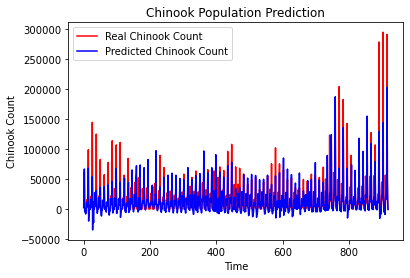

The root mean squared error is 17317.243859199847.


In [73]:
plot_predictions(y_train, train_preds_LSTM)
return_rmse(y_train, train_preds_LSTM)

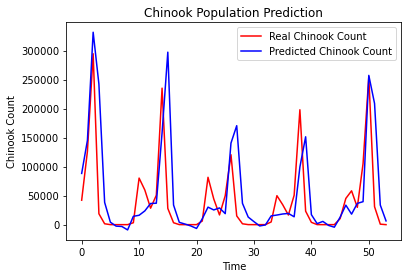

The root mean squared error is 66531.72241765632.


In [74]:
plot_predictions(y_test, test_preds_LSTM)
return_rmse(y_test, test_preds_LSTM)

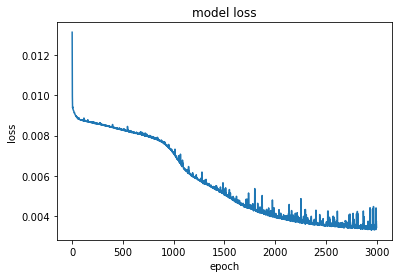

In [75]:
plot_loss(history_LSTM)

In [76]:
# global var for baseline
y_test_year = month_to_year(y_test)

49


In [77]:
y_test_year = month_to_year(y_test)
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
y_test_year = y_test_year.astype(np.int64)

49


In [78]:
# Comparing RMSE to curr Forecasting methods to LSTM
LSTM_test_year = month_to_year(test_preds_LSTM)
LSTM_test_year = LSTM_test_year.astype(np.int64)

49


In [79]:
LSTM_test_year

,Count
0,606305
1,457613
2,366556
3,642477


In [80]:
# test RMSE with baseline and LSTM
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, LSTM_test_year)

The root mean squared error is 115854.5707848853.
The root mean squared error is 100206.57175554904.
